# Description

This notebook gathers the analysis and reasoning for the requested tasks. It is presented as a document to follow and to explore it while running the code, in order to make it more "interactive", in a sudo narrative way (please note that there are custom assertions, in case you want to run all the cells at once).

You can check the instructions of usage of CLI in the README.md file.

Before anything, you can check the app that resulted from the exercise, where you can input for prediction and training (files to be used with this app can be found in the "artifacts" folder:

https://yay-or-nay-app.herokuapp.com/




I hope you enjoy!

# Load packages

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import joblib
import os
import category_encoders
import pandas as pd
import scipy.stats as ss
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from collections import Counter

from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
)
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from inspect import signature

import utils

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
OUTPUT_FOLDER = "artifacts/"
DATA_FOLDER = "data/"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

<IPython.core.display.Javascript object>

# Loading the data

The raw files are in the "data" folder.

In [4]:
print("Loading data...")
train = pd.read_csv(DATA_FOLDER + "training.csv", delimiter=";")
valid = pd.read_csv(DATA_FOLDER + "validation.csv", delimiter=";")

print(f"Shape of train data frame is: {train.shape}")
print(f"Shape of valid data frame is: {valid.shape}")

Loading data...
Shape of train data frame is: (3700, 19)
Shape of valid data frame is: (200, 19)


<IPython.core.display.Javascript object>

# Exploratory Data Analysis:

Firstly, time to look at the data provided!

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 19 columns):
v1            3661 non-null object
v2            3661 non-null object
v3            3700 non-null object
v4            3636 non-null object
v5            3636 non-null object
v6            3634 non-null object
v7            3634 non-null object
v8            3700 non-null object
v9            3700 non-null object
v10           3700 non-null object
v11           3700 non-null int64
v12           3700 non-null object
v13           3700 non-null object
v14           3600 non-null float64
v15           3700 non-null int64
v17           3600 non-null float64
v18           1555 non-null object
v19           3700 non-null int64
classLabel    3700 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 549.3+ KB


<IPython.core.display.Javascript object>

In [6]:
train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel
0,a,"17,92","5,4e-05",u,g,c,v,"1,75",f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,"16,92","3,35e-05",y,p,k,v,"0,29",f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,"31,25","0,0001125",u,g,ff,ff,0,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,"48,17","0,0001335",u,g,i,o,"0,335",f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,"32,33","0,00035",u,g,k,v,"0,5",f,f,0,t,g,232.0,0,2320000.0,f,0,no.


<IPython.core.display.Javascript object>

In [7]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 19 columns):
v1            197 non-null object
v2            197 non-null object
v3            200 non-null object
v4            198 non-null object
v5            198 non-null object
v6            197 non-null object
v7            197 non-null object
v8            200 non-null object
v9            200 non-null object
v10           200 non-null object
v11           200 non-null int64
v12           200 non-null object
v13           200 non-null object
v14           197 non-null float64
v15           200 non-null int64
v17           197 non-null float64
v18           89 non-null object
v19           200 non-null int64
classLabel    200 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 29.8+ KB


<IPython.core.display.Javascript object>

In [8]:
valid.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel
0,b,"32,33","0,00075",u,g,e,bb,"1,585",t,f,0,t,s,420.0,0,4200000.0,NaN,1,no.
1,b,"23,58","0,000179",u,g,c,v,"0,54",f,f,0,t,g,136.0,1,1360000.0,NaN,0,no.
2,b,"36,42","7,5e-05",y,p,d,v,"0,585",f,f,0,f,g,240.0,3,2400000.0,NaN,1,no.
3,b,"18,42","0,0010415",y,p,aa,v,"0,125",t,f,0,f,g,120.0,375,1200000.0,NaN,0,no.
4,b,"24,5","0,0013335",y,p,aa,v,"0,04",f,f,0,t,g,120.0,475,1200000.0,f,1,no.


<IPython.core.display.Javascript object>

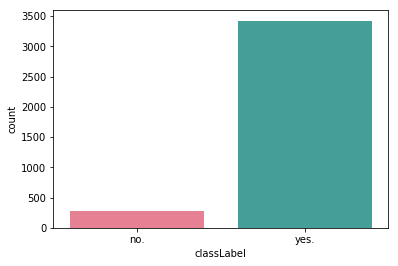

<IPython.core.display.Javascript object>

In [9]:
sns.countplot(x="classLabel", data=train, palette="husl")
plt.show()

In [10]:
train["classLabel"].value_counts(normalize=True)

yes.    0.925405
no.     0.074595
Name: classLabel, dtype: float64

<IPython.core.display.Javascript object>

* The dataset we have for training is highly imbalanced.

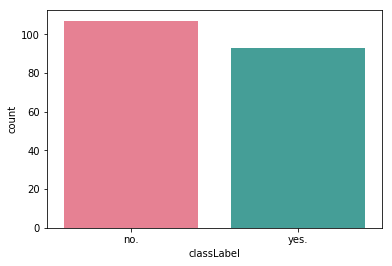

<IPython.core.display.Javascript object>

In [11]:
sns.countplot(x="classLabel", data=valid, palette="husl")
plt.show()

In [12]:
df = train.copy()

<IPython.core.display.Javascript object>

## Duplicates and missing values

### duplicate rows

What about duplicate data?

In [13]:
assert df.duplicated().sum() == 0, "Data has duplicates!!! Do your thing, please."

AssertionError: Data has duplicates!!! Do your thing, please.

<IPython.core.display.Javascript object>

Roger that!
Let's take a look at it.

In [14]:
is_duplicate = df.duplicated()

is_duplicate.value_counts(normalize=True)

True     0.867568
False    0.132432
dtype: float64

<IPython.core.display.Javascript object>

In [15]:
print(
    f"Roughly, {round(is_duplicate.value_counts(normalize=True)[1], 3) * 100}% of the data has duplicates, it's troublesome."
)

Roughly, 86.8% of the data has duplicates, it's troublesome.


<IPython.core.display.Javascript object>

Checking an example.

In [16]:
df[is_duplicate]

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel
490,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
491,a,"33,67","3,75e-05",u,g,cc,v,"0,375",f,f,0,f,g,300.0,44,3000000.0,NaN,1,yes.
492,b,45,"0,00085",u,g,cc,h,14,t,t,1,t,g,88.0,2000,880000.0,t,1,yes.
493,b,"33,17","0,000104",u,g,r,h,"6,5",t,f,0,t,g,164.0,31285,1640000.0,NaN,1,yes.
494,a,25,"8,75e-05",u,g,x,h,"1,04",t,f,0,t,g,160.0,5860,1600000.0,f,1,yes.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,a,"18,75","0,00075",u,g,q,v,"2,71",t,t,5,f,g,NaN,26726,NaN,t,1,yes.
3696,a,"23,5",9e-04,u,g,q,v,"8,5",t,t,5,t,g,120.0,0,1200000.0,t,1,yes.
3697,b,"34,17","0,000917",u,g,c,v,"4,5",t,t,12,t,g,0.0,221,0.0,NaN,1,yes.
3698,b,"27,83","0,000154",u,g,W,v,"3,75",t,t,5,t,g,100.0,3,1000000.0,NaN,1,yes.


<IPython.core.display.Javascript object>

In [17]:
df.loc[df["v2"] == "47,25", :]

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel
39,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
490,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
704,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
918,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
1132,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
1346,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
1560,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
1774,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
1988,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.
2202,a,"47,25","7,5e-05",u,g,q,h,"2,75",t,t,1,f,g,333.0,892,3330000.0,NaN,1,yes.


<IPython.core.display.Javascript object>

All these duplicates are not going to help our model, quite the opposite.

So, let's remove it.

In [18]:
print("Data shape before:", df.shape)
df = df.drop_duplicates(keep="first")
print("...and after droping duplicate rows:", df.shape)

Data shape before: (3700, 19)
...and after droping duplicate rows: (490, 19)


<IPython.core.display.Javascript object>

Is it still imbalanced?

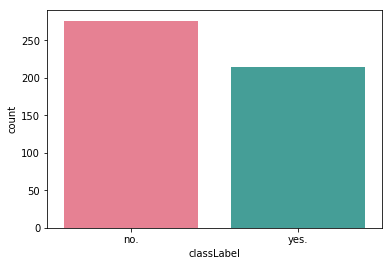

<IPython.core.display.Javascript object>

In [19]:
sns.countplot(x="classLabel", data=df, palette="husl")
plt.show()

Not anymore!

### missing values

Let's look at the percentage of missing vales in each column.

In [20]:
# % NAs

if any(df.isna()):
    print(df.isna().mean())

v1            0.018367
v2            0.018367
v3            0.000000
v4            0.008163
v5            0.008163
v6            0.012245
v7            0.012245
v8            0.000000
v9            0.000000
v10           0.000000
v11           0.000000
v12           0.000000
v13           0.000000
v14           0.020408
v15           0.000000
v17           0.020408
v18           0.551020
v19           0.000000
classLabel    0.000000
dtype: float64


<IPython.core.display.Javascript object>

There is missing data in a few columns, specially in v18, where more than half has missing values.
With such numbers, having such a small dataset, we decide to drop this column.


In [21]:
df = df.drop("v18", axis=1)

<IPython.core.display.Javascript object>

# Preprocessing

## Changing column types

Some of the columns don't have the correct type and have "," instead of "." in numbers, so let's change that.

In [24]:
cols_wrong_type = ["v2", "v3", "v8"]

for col in cols_wrong_type:

    df.loc[:, col] = pd.to_numeric(
        df.loc[:, col].astype(str).apply(lambda x: x.replace(",", ".")), errors="coerce"
    )

<IPython.core.display.Javascript object>

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 489
Data columns (total 18 columns):
v1            481 non-null object
v2            481 non-null float64
v3            490 non-null float64
v4            486 non-null object
v5            486 non-null object
v6            484 non-null object
v7            484 non-null object
v8            490 non-null float64
v9            490 non-null object
v10           490 non-null object
v11           490 non-null int64
v12           490 non-null object
v13           490 non-null object
v14           480 non-null float64
v15           490 non-null int64
v17           480 non-null float64
v19           490 non-null int64
classLabel    490 non-null object
dtypes: float64(5), int64(3), object(10)
memory usage: 92.7+ KB


<IPython.core.display.Javascript object>

In [26]:
df.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v19,classLabel
0,a,17.92,0.000054,u,g,c,v,1.75,f,t,1,t,g,80.0,5,800000.0,0,no.
1,b,16.92,0.000034,y,p,k,v,0.29,f,f,0,f,s,200.0,0,2000000.0,0,no.
2,b,31.25,0.000112,u,g,ff,ff,0.00,f,t,1,f,g,96.0,19,960000.0,0,no.


<IPython.core.display.Javascript object>

In [27]:
df.describe()

,v2,v3,v8,v11,v14,v15,v17,v19
count,481.000000,490.000000,490.000000,490.000000,480.000000,490.000000,4.800000e+02,490.000000
mean,31.357235,0.000482,2.299561,2.238776,177.493750,1163.371429,1.774938e+06,0.436735
std,11.859824,0.000500,3.564516,5.092812,156.680759,6093.186885,1.566808e+06,0.496488
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,22.500000,0.000104,0.165000,0.000000,74.500000,0.000000,7.450000e+05,0.000000
50%,28.080000,0.000294,1.000000,0.000000,160.000000,5.000000,1.600000e+06,0.000000
75%,37.500000,0.000707,2.615000,2.000000,272.000000,345.250000,2.720000e+06,1.000000
max,80.250000,0.002800,28.500000,67.000000,1160.000000,100000.000000,1.160000e+07,1.000000


<IPython.core.display.Javascript object>

## Defining categorical and numerical columns

In [31]:
categorical_cols = list(train.select_dtypes(include=["O"]).columns)

<IPython.core.display.Javascript object>

In [32]:
numeric_cols = list(train.select_dtypes(exclude=["O"]).columns)

<IPython.core.display.Javascript object>

## Looking at the distribution of numeric columns

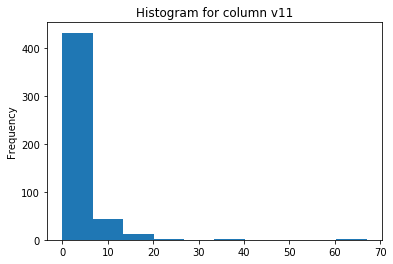

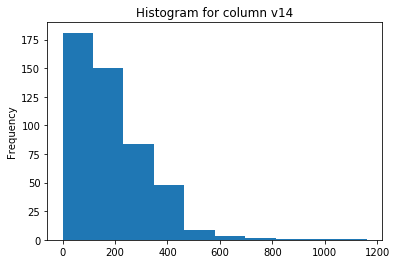

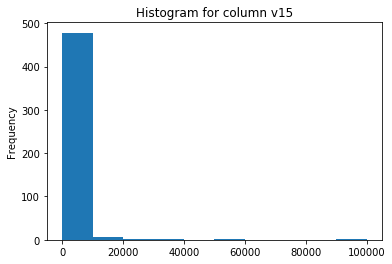

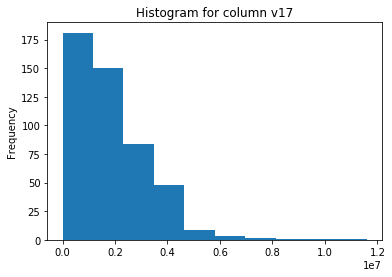

<IPython.core.display.Javascript object>

In [33]:
for col in numeric_cols:
    if col != "v19":  # boolean column
        df[col].plot.hist()
        plt.title(f"Histogram for column {col}")
        plt.show()

* The variables are highly skewewd and, in the case of "v15", the outliers can have great orders of magnitude.

# Correlations and associations

## Correlations

Correlation between the numeric inputs.

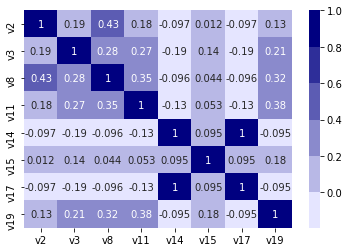

<IPython.core.display.Javascript object>

In [34]:
corr = df.corr()

# plot heatmap
sns.heatmap(
    corr,
    annot=True,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    cmap=sns.light_palette("navy"),
)
plt.show()

In [35]:
df.loc[:, ["v14", "v17"]].describe()

,v14,v17
count,480.000000,4.800000e+02
mean,177.493750,1.774938e+06
std,156.680759,1.566808e+06
min,0.000000,0.000000e+00
25%,74.500000,7.450000e+05
50%,160.000000,1.600000e+06
75%,272.000000,2.720000e+06
max,1160.000000,1.160000e+07


<IPython.core.display.Javascript object>

In [36]:
train.loc[:, ["v14", "v17"]].describe()

,v14,v17
count,3600.000000,3.600000e+03
mean,162.695000,1.626950e+06
std,156.045682,1.560457e+06
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,120.000000,1.200000e+06
75%,280.000000,2.800000e+06
max,1160.000000,1.160000e+07


<IPython.core.display.Javascript object>

* There is a strong correlation between columns "v14" and "v17". They are practically describing the same input, so it's safe to drop one of them.

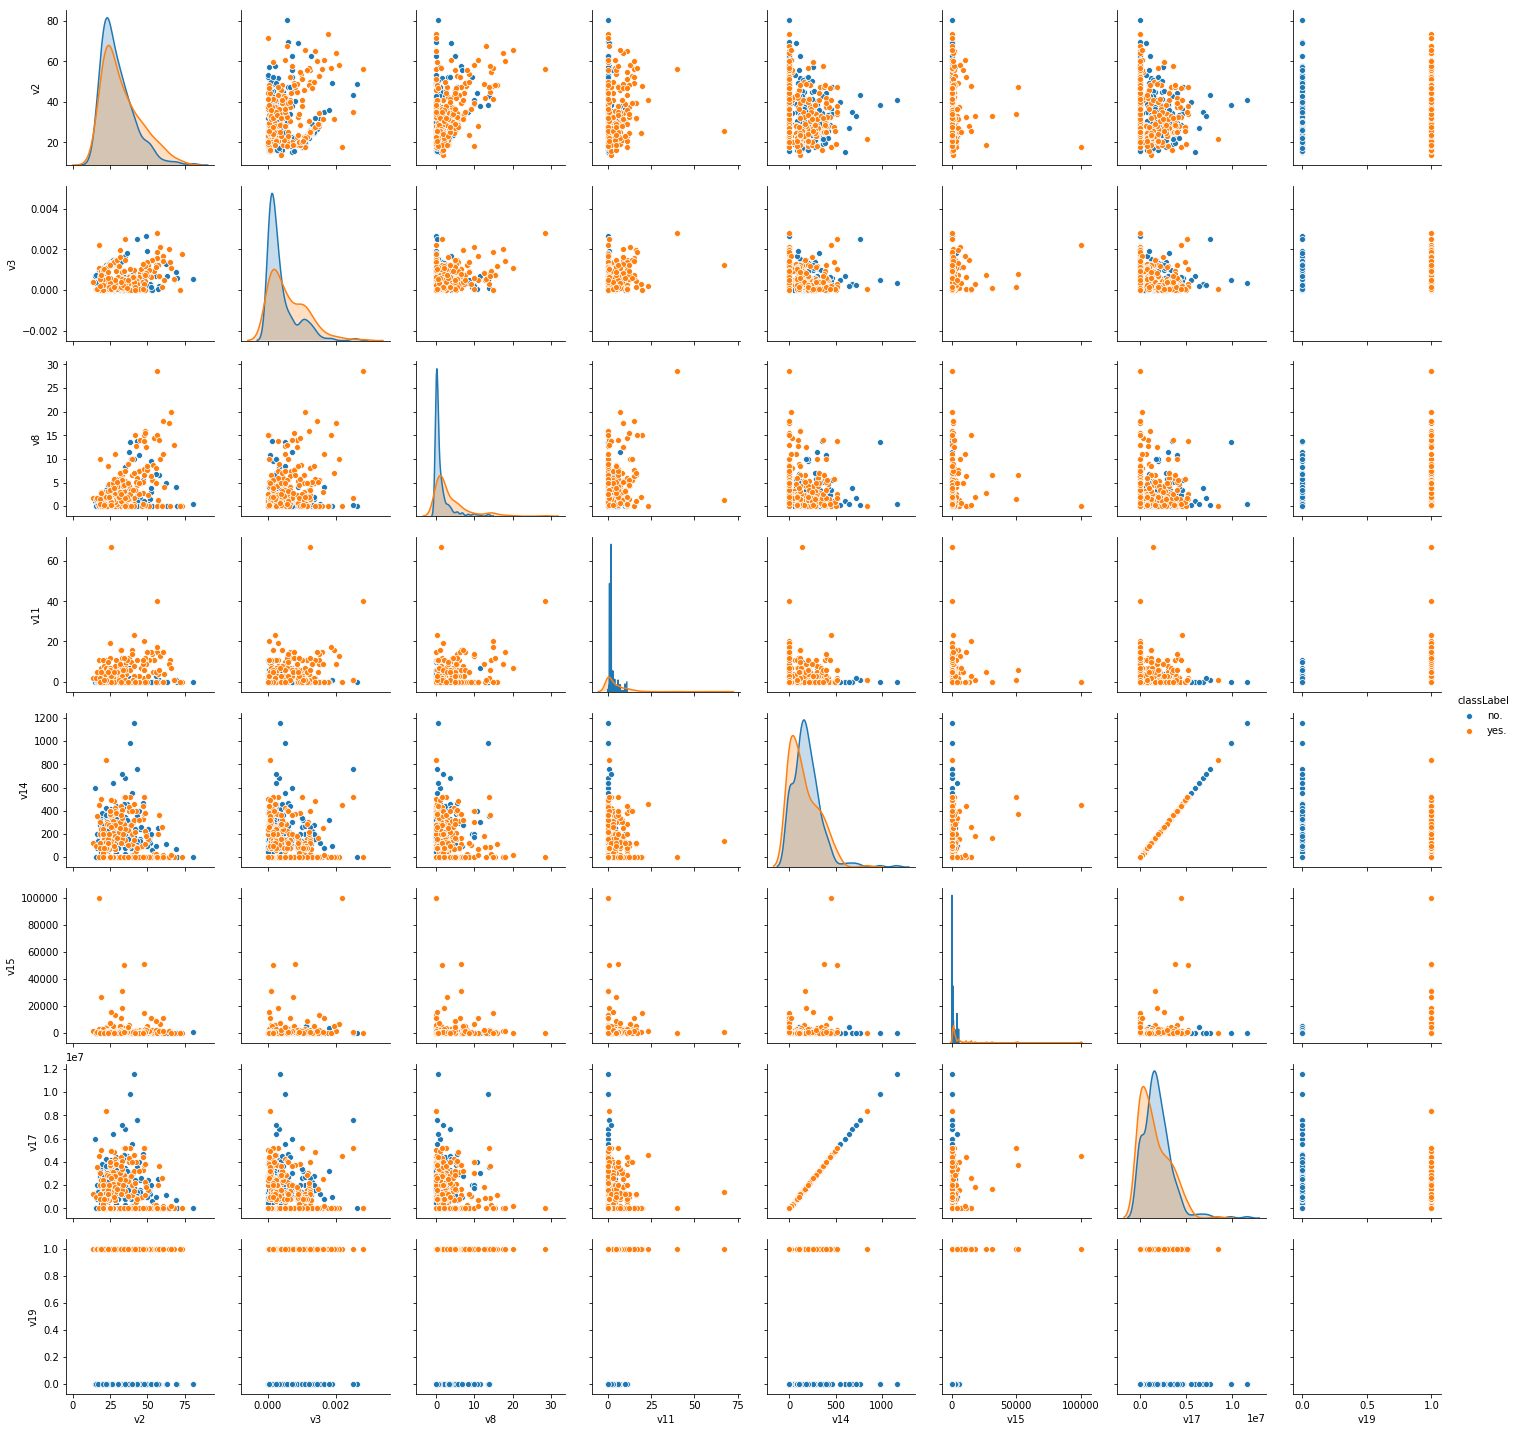

<IPython.core.display.Javascript object>

In [37]:
g = sns.pairplot(df, hue="classLabel")

In [38]:
pd.crosstab(index=train["v19"], columns=train["classLabel"])

classLabel,no.,yes.
v19,,
0,276,0
1,0,3424


<IPython.core.display.Javascript object>

* Interestingly, this pairplot becomes crucial. We can observe there, and with the help of a crosstab, that we could fall in the data leakage trap if we used the column "v19" for modelling.

Let's drop this feature as well.

In [42]:
df = df.drop(["v14", "v19"], axis=1)

<IPython.core.display.Javascript object>

In [43]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v15,v17,classLabel
0,a,17.92,0.000054,u,g,c,v,1.750,f,t,1,t,g,5,800000.0,no.
1,b,16.92,0.000034,y,p,k,v,0.290,f,f,0,f,s,0,2000000.0,no.
2,b,31.25,0.000112,u,g,ff,ff,0.000,f,t,1,f,g,19,960000.0,no.
3,a,48.17,0.000133,u,g,i,o,0.335,f,f,0,f,g,120,0.0,no.
4,b,32.33,0.000350,u,g,k,v,0.500,f,f,0,t,g,0,2320000.0,no.


<IPython.core.display.Javascript object>

# Create pipeline transformers

The pipeline that is going to be used to preprocess the data, before feeding it to the classifier and for validation.

## Preprocessing pipeline

### Drop columns

Creating the class for dropping columns in the datasets.

In [53]:
class DropCols(object):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def _delSameCols(self, cols_to_drop):
        cols = self.cols_to_drop
        cols = list(set(cols))
        #         print(u"      - %s features to be removed" % len(cols))
        return cols

    def transform(self, X):
        dat = X.copy()
        lstcols = list(set(dat.columns) - set(self.lstRemCols))
        return dat.loc[:, lstcols]

    def fit(self, X, y=None):
        dat = X.copy()
        self.lstRemCols = self._delSameCols(dat)
        return self

<IPython.core.display.Javascript object>

### Drop duplicates

The class to drop any duplicate rows.

In [54]:
class DataFrameTransf:
    def __init__(self):
        """
        Class that drops duplicate rows
        """

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        X = X.copy()

        X = X.drop_duplicates()

        return X

<IPython.core.display.Javascript object>

### Cleaning vars

Class to change column types and replace "," by "." in numbers

In [55]:
class ColumnTransf(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Class to change column types and replace "," by "." in numbers

        """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X = X.copy()
        cols_wrong_type = ["v2", "v3", "v8"]
        for col in cols_wrong_type:
            X.loc[:, col] = pd.to_numeric(
                X.loc[:, col].astype(str).apply(lambda x: x.replace(",", ".")),
                errors="coerce",
            )

        return X

<IPython.core.display.Javascript object>

### Missing values imputation

Imputation of missing values can have its dangers, and the decision of doing it (or dropping the features), will always depend on the business rules, data issues, etc.

In [59]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        self.fill = pd.Series(
            [
                X[c].value_counts().index[0]
                if X[c].dtype == np.dtype("O")
                else X[c].median()
                for c in X
            ],
            index=X.columns,
        )

        return X.fillna(self.fill)

<IPython.core.display.Javascript object>

## Classifier

In [119]:
# model = LinearSVC(random_state=42)
model = RandomForestClassifier(random_state=42)

<IPython.core.display.Javascript object>

# Training

## Define features

In [120]:
label = "classLabel"

# a list with the colums to drop during preprocessing (including the label that is encoder later)

cols_to_drop = ["v14", "v18", "v19", label]
numeric_cols = ["v2", "v3", "v8", "v11", "v14", "v15", "v17", "v19"]


numeric_features = [col for col in numeric_cols if col not in cols_to_drop]
categorical_features = [
    col
    for col in categorical_cols
    if col not in cols_to_drop and col not in numeric_features
]

<IPython.core.display.Javascript object>

## Full pipeline

In [121]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", SimpleImputer(strategy="median"))]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot", category_encoders.OneHotEncoder(handle_unknown="impute")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessing = Pipeline(
    [
        ("col_transf", ColumnTransf()),  # cleans cols
        ("remove_cols", DropCols(cols_to_drop)),  # removes cols
        ("remove_dups", DataFrameTransf()),  # removes dups
        ("preprocessor", preprocessor),
    ]
)

<IPython.core.display.Javascript object>

### Fitting the pipeline

In [122]:
preprocessing.fit(train)

Pipeline(memory=None,
         steps=[('col_transf', ColumnTransf()),
                ('remove_cols',
                 <__main__.DropCols object at 0x0000019A91043CC0>),
                ('remove_dups',
                 <__main__.DataFrameTransf object at 0x0000019A910436D8>),
                ('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('s...
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
       

<IPython.core.display.Javascript object>

### Transforming both datasets

In [123]:
full_df = preprocessing.fit_transform(train)
valid_df = preprocessing.transform(valid)

<IPython.core.display.Javascript object>

In [124]:
print(full_df.shape)
print(valid_df.shape)

(490, 51)
(200, 51)


<IPython.core.display.Javascript object>

In [125]:
pd.DataFrame(full_df).head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.134184,-0.857813,-0.154333,-0.243489,-0.190304,-0.622894,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.218590,-0.898870,-0.564344,-0.440044,-0.191125,0.143794,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.009051,-0.740651,-0.645785,-0.243489,-0.188004,-0.520669,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

## Splitting datasets for training and testing

Testing dataset size: 20%

In [126]:
train_no_dups = train.drop_duplicates()
train_label = train_no_dups["classLabel"]

<IPython.core.display.Javascript object>

Encoding the label

In [127]:
le = LabelEncoder()
le.fit(train_label)
train_label = le.transform(train_label)

<IPython.core.display.Javascript object>

In [128]:
joblib.dump(le, OUTPUT_FOLDER + "/label_encoder.pickle")  # saving the label encoder

['artifacts//label_encoder.pickle']

<IPython.core.display.Javascript object>

In [129]:
# label = full_df[:, -1]
# df_features = full_df[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(
    full_df, train_label, test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

In [130]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(392, 51)
(98, 51)
(392,)
(98,)


<IPython.core.display.Javascript object>

## Fitting our model

In [131]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

## Results

In [132]:
# Validate on test set
print("Preparing for validation...")
predicted = model.predict(X_test)
print("Results almost showing...")

# Print the results

print("Results: \nAccuracy:", round(accuracy_score(y_test, predicted), 2))
print("F1-score:", round(f1_score(y_test, predicted, average="macro"), 2))
print("Precision:", round(precision_score(y_test, predicted, average="macro"), 2))
print("Recall:", round(recall_score(y_test, predicted, average="macro"), 2))

Preparing for validation...
Results almost showing...
Results: 
Accuracy: 0.91
F1-score: 0.9
Precision: 0.91
Recall: 0.9


<IPython.core.display.Javascript object>

In [133]:
print("ROC AUC score:", roc_auc_score(y_test, predicted))

ROC AUC score: 0.9030172413793103


<IPython.core.display.Javascript object>

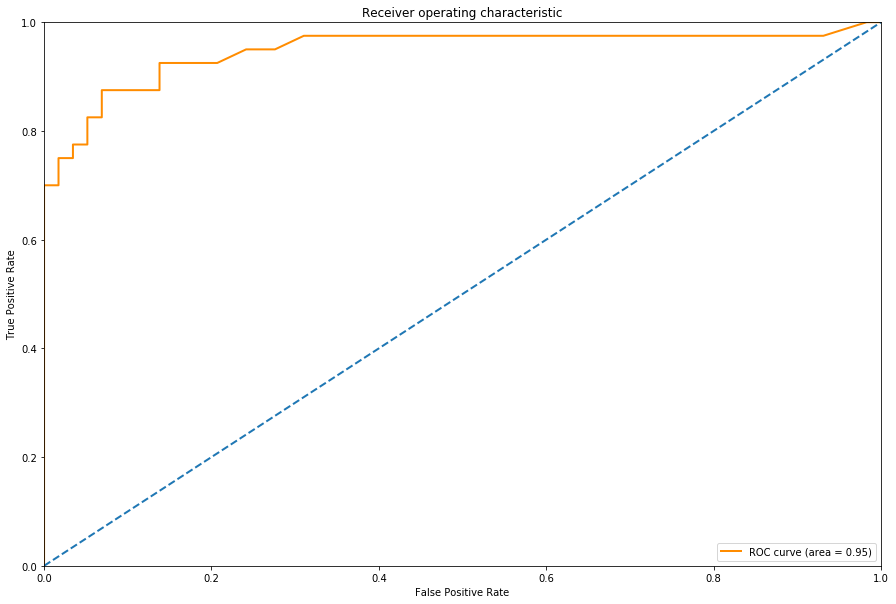

<IPython.core.display.Javascript object>

In [134]:
y_pred = [x[1] for x in model.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.95')

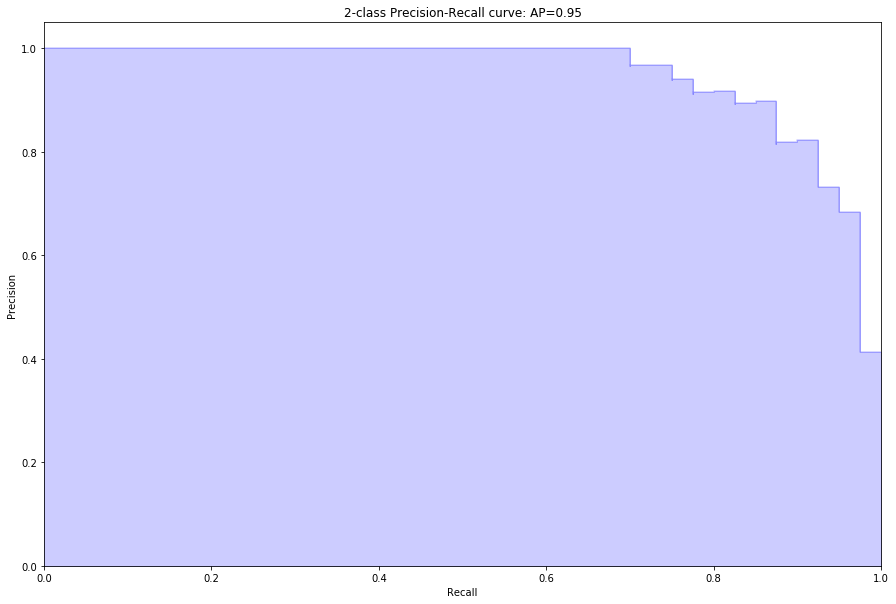

<IPython.core.display.Javascript object>

In [135]:
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = (
    {"step": "post"} if "step" in signature(plt.fill_between).parameters else {}
)

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision))

In [136]:
features = np.array(pd.DataFrame(X_train).columns)
importances = np.array(model.feature_importances_)
feat_imp = np.concatenate([features, importances])

feat_imp = dict(zip(features, importances))

feat_importance = pd.DataFrame(feat_imp, index=[0]).T.sort_values(by=0, ascending=False)
feat_importance[:10]

,0
43,0.179838
42,0.150341
2,0.078159
1,0.068569
4,0.066014
3,0.061952
5,0.061748
0,0.049597
45,0.034250
44,0.024301


<IPython.core.display.Javascript object>

Normalized confusion matrix


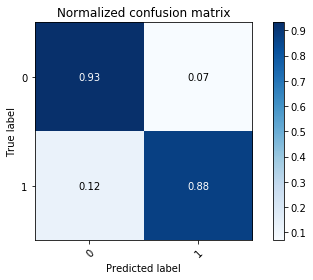

<IPython.core.display.Javascript object>

In [137]:
utils.plot_confusion_matrix(
    y_test,
    predicted,
    normalize=True,
    classes=[0, 1],
    title="Normalized confusion matrix",
)
plt.show()

In [138]:
def print_report(y_test, y_pred):

    report = classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))


print_report(y_test, predicted)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92        58
           1       0.90      0.88      0.89        40

    accuracy                           0.91        98
   macro avg       0.91      0.90      0.90        98
weighted avg       0.91      0.91      0.91        98

accuracy: 0.908


<IPython.core.display.Javascript object>

# Validating on validation dataset

In [139]:
valid_no_dups = valid.drop_duplicates()
valid_label = valid_no_dups.pop("classLabel")

le = LabelEncoder()
le.fit(valid_label)
y_valid_decod = le.transform(valid_label)

<IPython.core.display.Javascript object>

In [140]:
valid_preds = model.predict(valid_df)

print("Results: \nAccuracy:", round(accuracy_score(y_valid_decod, valid_preds), 2))
print("F1-score:", round(f1_score(y_valid_decod, valid_preds, average="macro"), 2))
print(
    "Precision:", round(precision_score(y_valid_decod, valid_preds, average="macro"), 2)
)
print("Recall:", round(recall_score(y_valid_decod, valid_preds, average="macro"), 2))

Results: 
Accuracy: 0.89
F1-score: 0.89
Precision: 0.89
Recall: 0.89


<IPython.core.display.Javascript object>

Normalized confusion matrix


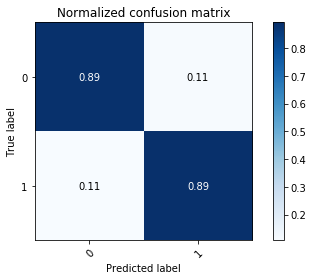

<IPython.core.display.Javascript object>

In [141]:
utils.plot_confusion_matrix(
    y_valid_decod,
    valid_preds,
    normalize=True,
    classes=[0, 1],
    title="Normalized confusion matrix",
)
plt.show()

In [142]:
print("ROC AUC score:", roc_auc_score(y_valid_decod, valid_preds))

ROC AUC score: 0.8901617927846448


<IPython.core.display.Javascript object>

In [143]:
print_report(y_valid_decod, valid_preds)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       107
           1       0.87      0.89      0.88        93

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

accuracy: 0.890


<IPython.core.display.Javascript object>

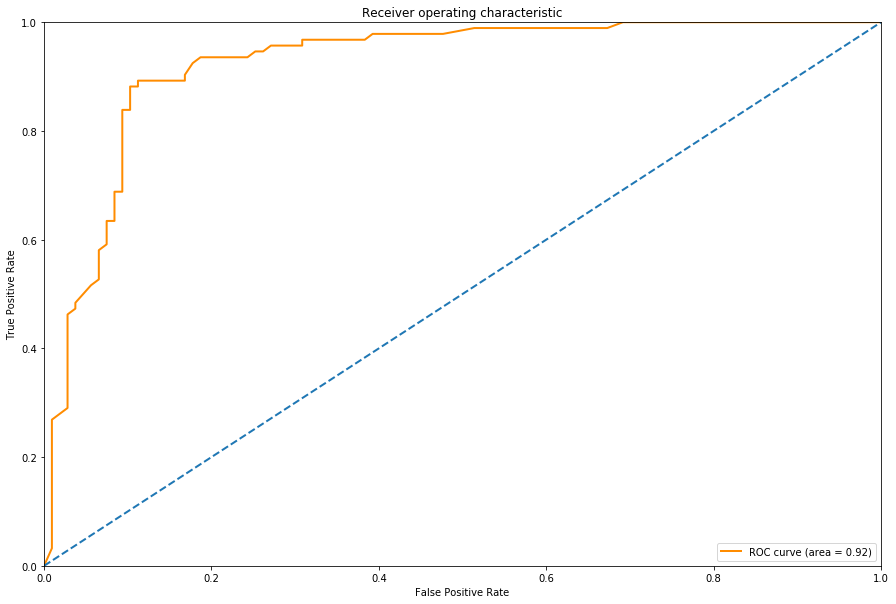

<IPython.core.display.Javascript object>

In [144]:
y_pred = [x[1] for x in model.predict_proba(valid_df)]
fpr, tpr, thresholds = roc_curve(y_valid_decod, y_pred, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Decision on the model

In this notebook, it is presented the results of using a Random Forest. 

At the "Classifier" chapter, you have the option to change it to LinearSCV (a Linear Support Vector Classifier, using liblinear that can help on the predictio of the positive class and in terms of data scalling) -- or other, if you wish.

Since we don't have much information on the meaning of the class label of the datasets provided, it is difficult to take a decisive and final directing choice towards a final model or metric.

I rely right now on F1-score, so the choice, for now, falls on the Random Forest classifier, since its value is higher, comparing to the alternative LinearSVC (89% vs 83%, respectively). But, if it's more urgent to identify true positives, your choice, as the "client" with the business knowledge, should fall on the LinearSVC classifier, since Recall is higher on the **positive class** (94% vs 89%).

After clarifying the business rules, more tuning on the hyparameters in the right direction should be mandatory.

The resume of the main metrics for both models follows:

* Random Forest:

    Accuracy: 0.89

    F1-score: 0.89

    Precision: 0.89

    Recall: 0.89
    

* LinearSVC:

    Accuracy: 0.84

    F1-score: 0.83

    Precision: 0.85

    Recall: 0.84




# Deployment

The resulting code for this exercise was used in the deployment of an app that was deployed in heroku. Please, feel free to give feedback on any features that need to be changed or added.

# End notes

Test the scripts in the CLI and the app!

Thanks for reading this, specially if you got this far!